#Prediccion del valor de un inmueble en Perú

Este dataset fue extraido de Kaggle el cual tiene el nombre de [house_pricing_lima_peru](https://www.kaggle.com/datasets/pbenavides/house-pricing-lima-peru)

✅ Instalación de Librerías Necesarias

In [ ]:
!pip install xgboost
!pip install shap

📚 Importar Librerías a utilizar y se carga el dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from matplotlib.ticker import FuncFormatter
from google.colab import drive
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cargamos los datos
drive.mount('/content/drive')
csv_path = "/content/drive/MyDrive/urbania_data.csv"
df = pd.read_csv(csv_path)

# Formato de precios legible
def formato_miles(x, pos):
    return f'S/ {int(x):,}'.replace(',', '.')
formatter = FuncFormatter(formato_miles)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ⛏ 1. Exploracion de Datos

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7663 entries, 0 to 7662
Data columns (total 96 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0.1                    7663 non-null   int64  
 1   Unnamed: 0                      7663 non-null   int64  
 2   Antiguedad                      7663 non-null   float64
 3   Anunciante                      7663 non-null   object 
 4   Balneario                       7663 non-null   object 
 5   NroBanios                       7663 non-null   float64
 6   Nro_pisos                       7663 non-null   float64
 7   Cocheras                        7663 non-null   float64
 8   Descripcion                     7663 non-null   object 
 9   Direccion                       7663 non-null   object 
 10  Dormitorios                     7663 non-null   object 
 11  Estado de Inmueble              7663 non-null   object 
 12  Fecha_pub                       76

In [ ]:
print(df.columns.tolist())

['Unnamed: 0.1', 'Unnamed: 0', 'Antiguedad', 'Anunciante', 'Balneario', 'NroBanios', 'Nro_pisos', 'Cocheras', 'Descripcion', 'Direccion', 'Dormitorios', 'Estado de Inmueble', 'Fecha_pub', 'Luminosidad', 'Mascotas', 'Precio', 'Tipo', 'TipoCochera', 'Ubicacion', 'Uso_comercial', 'Uso_profesional', 'latitud', 'longitud', 'Area_constr', 'Area_total', 'Area_constr_m2', 'Area_total_m2', 'match', "'Cuarto de servicio'", "'Deposito'", "'Terraza'", "'Kitchenette'", "'Sala de estar'", "'Sotano'", "'Patio'", "'anx81tico'", "'Comedor diario'", "'Comedor'", "'Banio de servicio'", "'Jardanxadn Interno'", "'Walking Closet'", "'Escritorio'", "'Cocina'", "'Banio independiente'", "'Lavanderanxada'", "'Balcon'", "'Sala'", "'Closet'", "'Banio de visitas'", "'Agua'", "'Guardiananxada'", "'Internet'", "'Luz'", "'Cable'", "'Servicio de Limpieza'", "'Conexion a gas'", "'Sistema de seguridad'", "'Telefono'", "'Areadeportiva'", "'Piscina'", "'Solarium'", "'Sala de internet'", "'Sala de cine'", "'Jardanxadn'", "

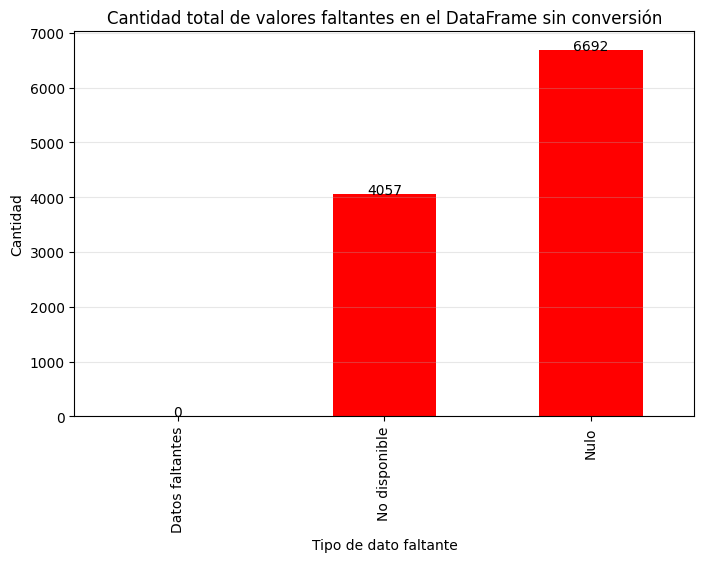

In [ ]:
total_nulos = df.isnull().sum().sum()
total_no_disponible = (df == "No disponible").sum().sum()
total_Nulo = (df == "Nulo").sum().sum()

# 2. Creamos un diccionario para el gráfico
data_faltantes = {
    "Datos faltantes": total_nulos,
    "No disponible": total_no_disponible,
    "Nulo": total_Nulo,
}

# 3. Convertimos a Series para graficar
series_faltantes = pd.Series(data_faltantes)

# 4. Graficamos
plt.figure(figsize=(8, 5))
series_faltantes.plot(kind='bar', color=['red'])
plt.title("Cantidad total de valores faltantes en el DataFrame sin conversión")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de dato faltante")
plt.grid(axis='y', alpha=0.3)

# Mostrar valores encima de las barras
for i, valor in enumerate(series_faltantes):
    plt.text(i, valor + 0.5, str(valor), ha='center')

plt.show()

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Antiguedad,Anunciante,Balneario,NroBanios,Nro_pisos,Cocheras,Descripcion,Direccion,...,'Aire acondicionado','Amoblado','Sauna','Calefaccion','Equipado','Terma','Portero electrico','Cocina con reposteros',Distrito,Provincia
0,0,3,5.0,Valentinoinmobiliaria,Nulo,4.0,2.0,3.0,excelente opcion para vivir en una de las mej...,"Malecon Monte Bello 5 La Molina, La Planicie, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LaMolina,Lima
1,1,4,5.0,No disponible,Nulo,5.0,3.0,1.0,hermosa casa a espalda de futura avenida prol...,Mz. O2 Lt. 03 Urb. San Antonio De Carapongo 2 ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lurigancho,Lima
2,2,5,3.0,No disponible,Nulo,5.0,3.0,4.0,casa de estreno acabados de primera. calle ce...,"El Pinar 120 , La Planicie 1era Etapa La Molin...",...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,LaMolina,Lima
3,5,8,1.0,No disponible,Sol Y Mar,5.0,2.0,3.0,linda casa en condominio con piscina club hou...,"Km 98.5 De La Panamericana Sur Asia, Sol Y Mar...",...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Asia,Lima
4,6,9,4.0,No disponible,Nulo,4.0,2.0,2.0,monterrico 2 casas en 1 ( casa bajos 4 dormit...,"Mariano De Rivera Y Ustariz #215 Surco, Huerto...",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,SantiagoDeSurco,Lima


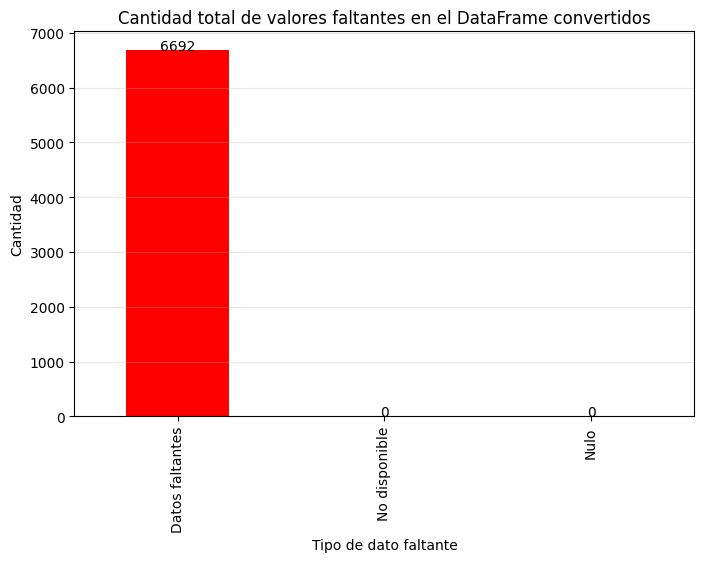

In [ ]:
# Quitar columnas irrelevantes
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Anunciante', 'Descripcion', 'Direccion', 'Fecha_pub', 'Muy luminoso', 'Ubicacion'], errors='ignore', inplace=True)

# Reemplazar strings que representan nulos
df.replace(to_replace=['Nulo', 'null', 'Null', 'NA', 'N/A', '', 'No disponible'], value=np.nan, inplace=True)

total_nulos = df.isnull().sum().sum()
total_no_disponible = (df == "No disponible").sum().sum()
total_Nulo = (df == "Nulo").sum().sum()

# 2. Creamos un diccionario para el gráfico
data_faltantes = {
    "Datos faltantes": total_nulos,
    "No disponible": total_no_disponible,
    "Nulo": total_Nulo,
}

# 3. Convertimos a Series para graficar
series_faltantes = pd.Series(data_faltantes)

# 4. Graficamos
plt.figure(figsize=(8, 5))
series_faltantes.plot(kind='bar', color=['red'])
plt.title("Cantidad total de valores faltantes en el DataFrame convertidos")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de dato faltante")
plt.grid(axis='y', alpha=0.3)

# Mostrar valores encima de las barras
for i, valor in enumerate(series_faltantes):
    plt.text(i, valor + 0.5, str(valor), ha='center')

plt.show()


--- Información del dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7663 entries, 0 to 7662
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Antiguedad                      7663 non-null   float64
 1   Balneario                       971 non-null    object 
 2   NroBanios                       7663 non-null   float64
 3   Nro_pisos                       7663 non-null   float64
 4   Cocheras                        7663 non-null   float64
 5   Dormitorios                     7663 non-null   object 
 6   Estado de Inmueble              7663 non-null   object 
 7   Luminosidad                     7663 non-null   object 
 8   Mascotas                        7663 non-null   object 
 9   Precio                          7663 non-null   float64
 10  Tipo                            7663 non-null   object 
 11  TipoCochera                     7663 non-null   object 
 12  U

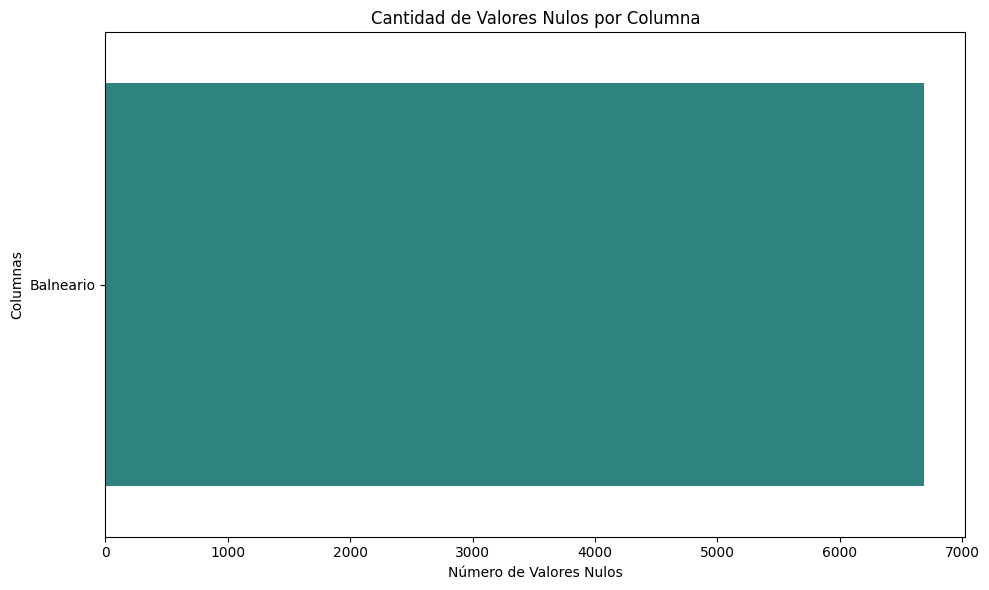

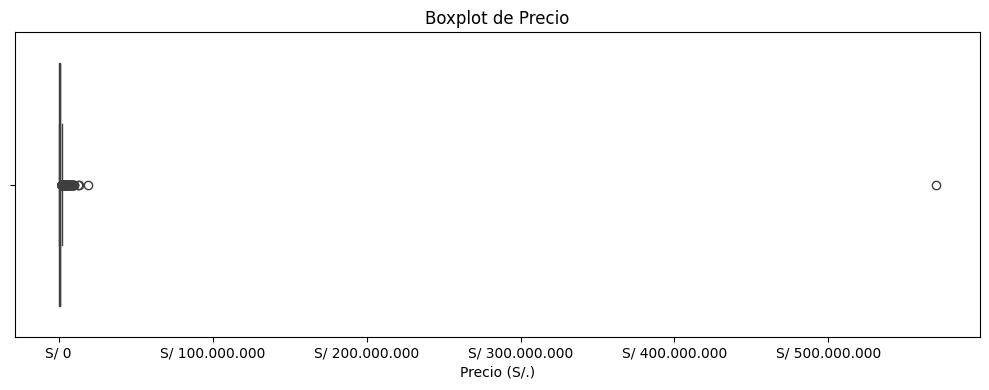

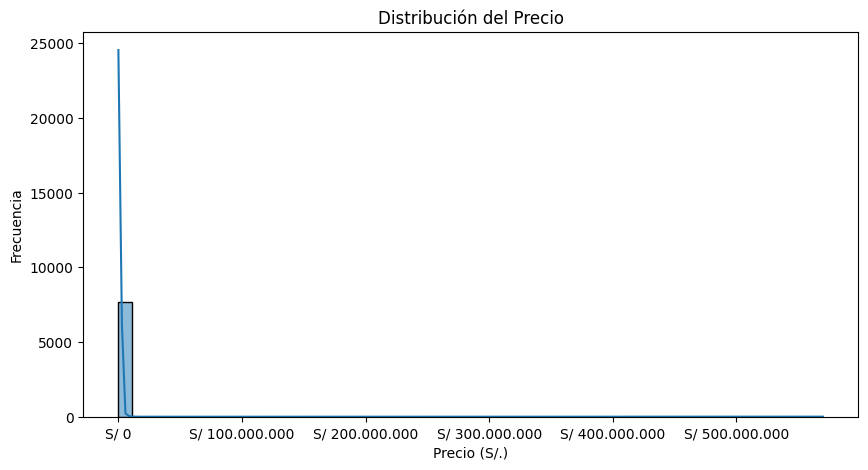

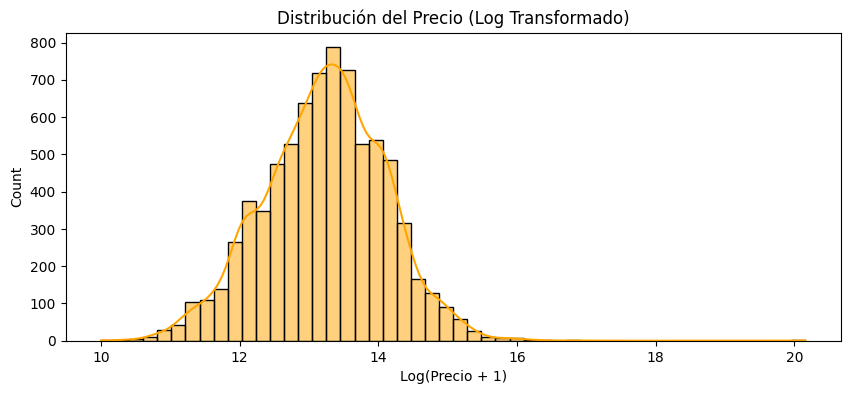

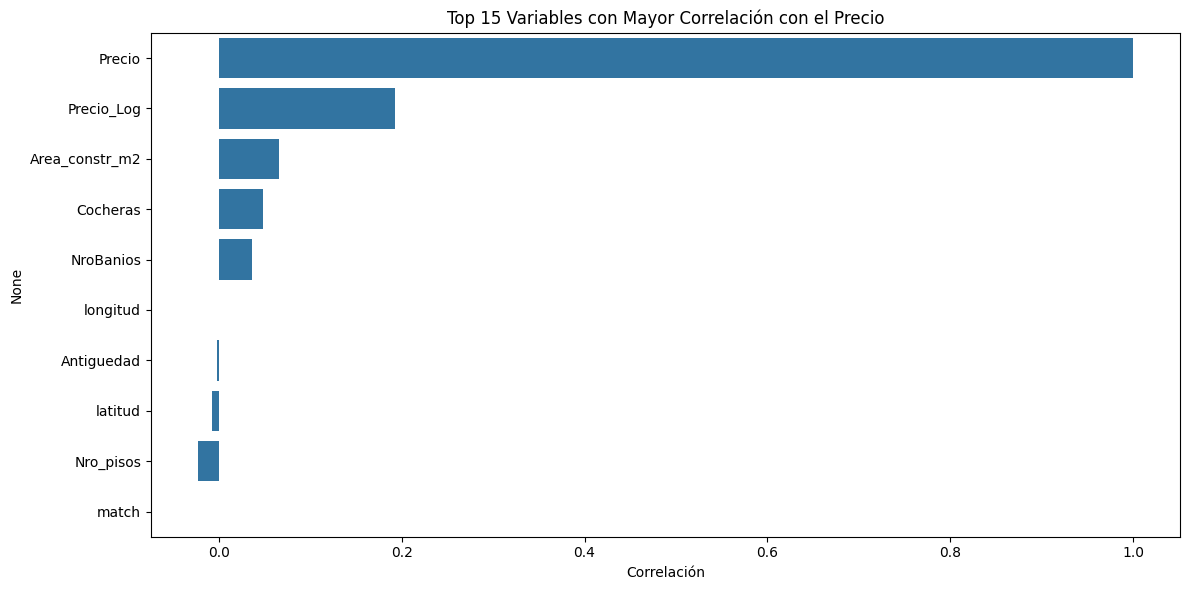

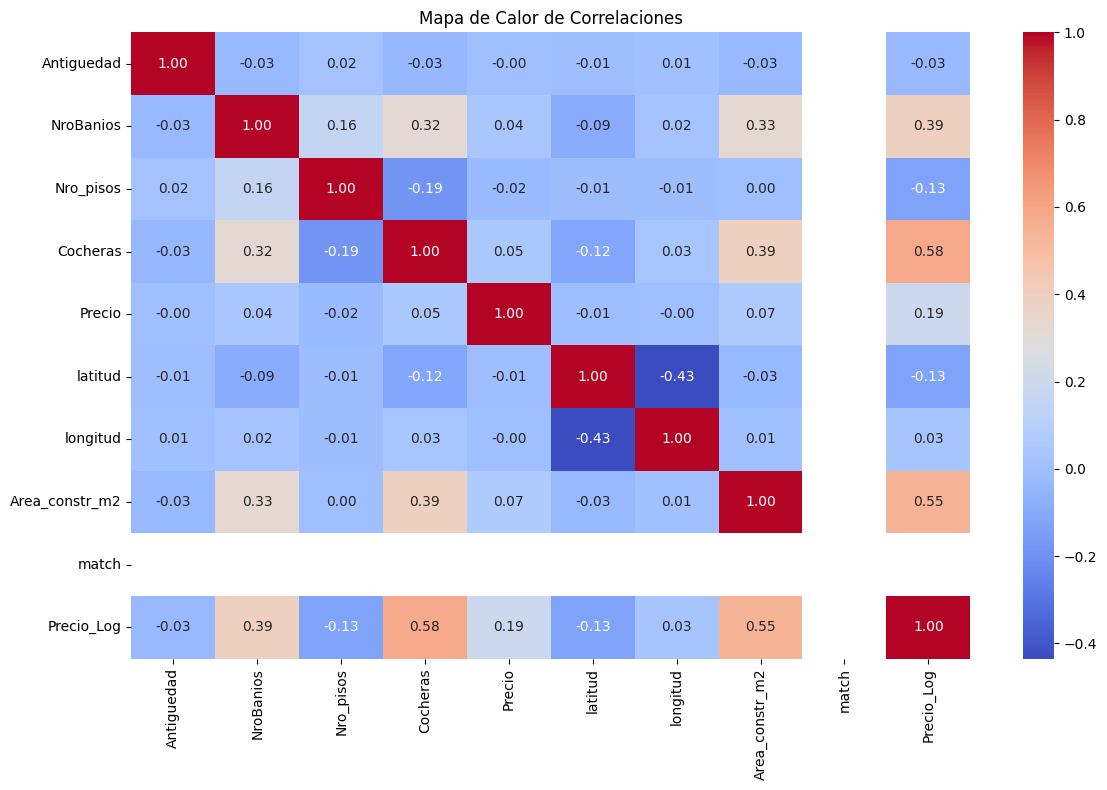

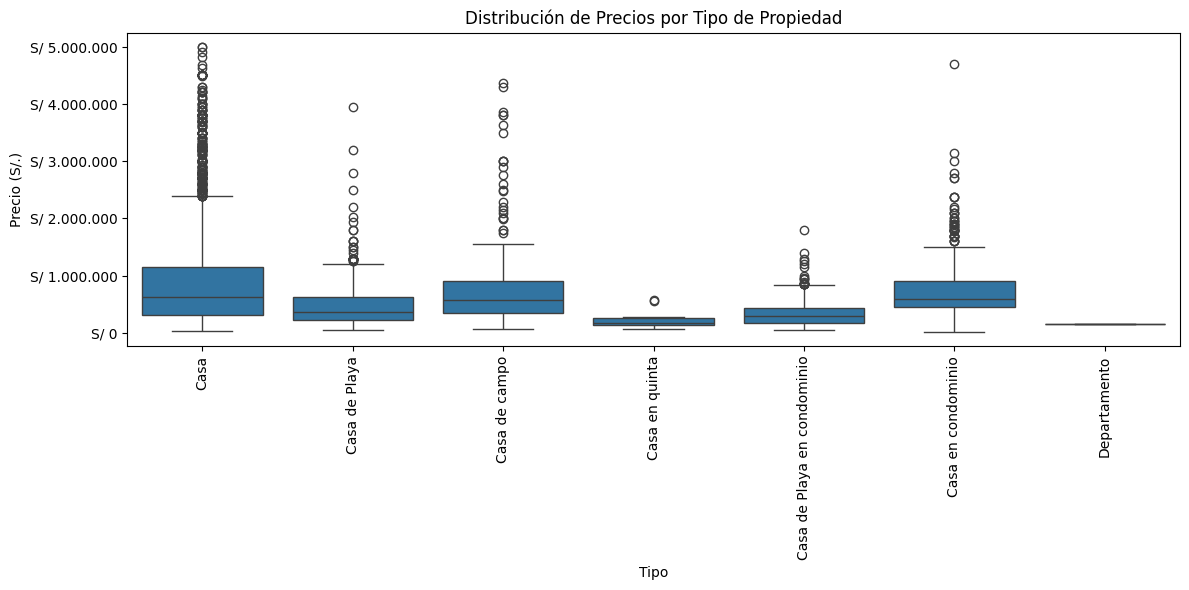

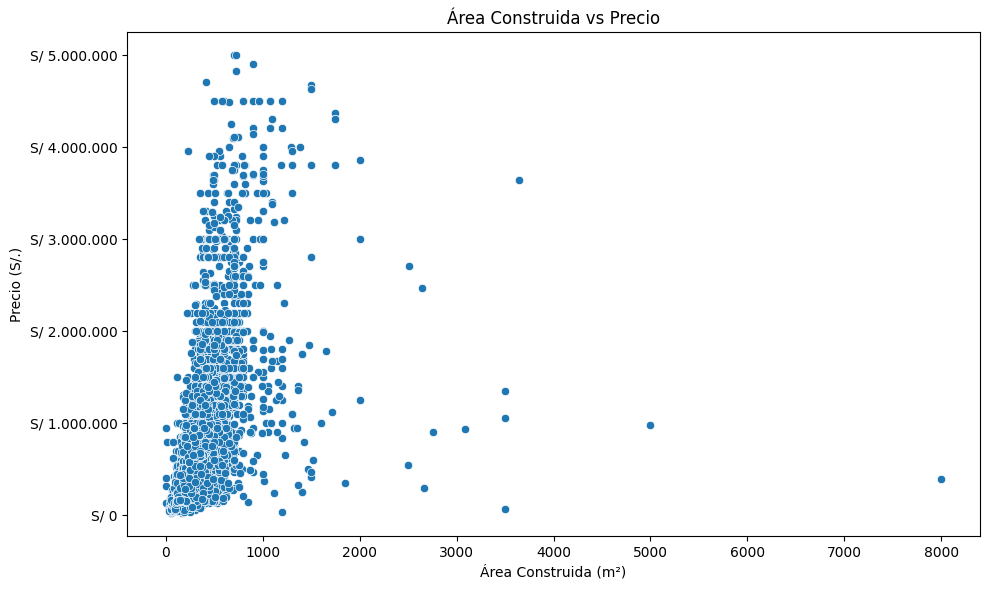

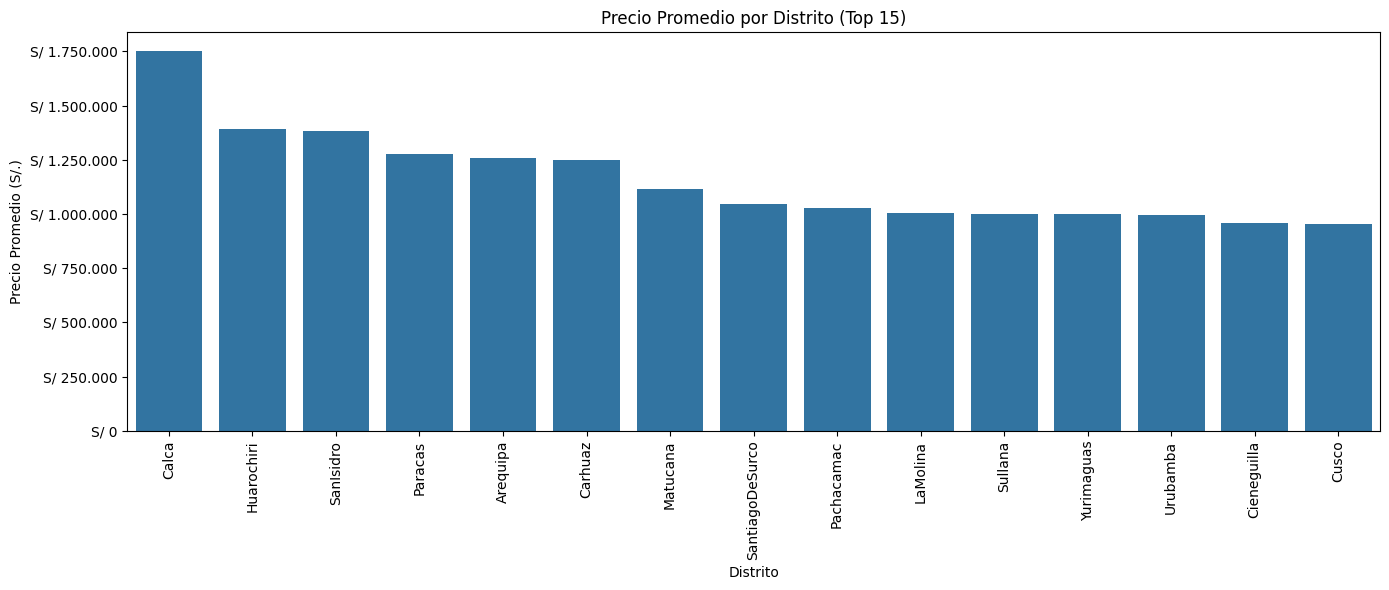

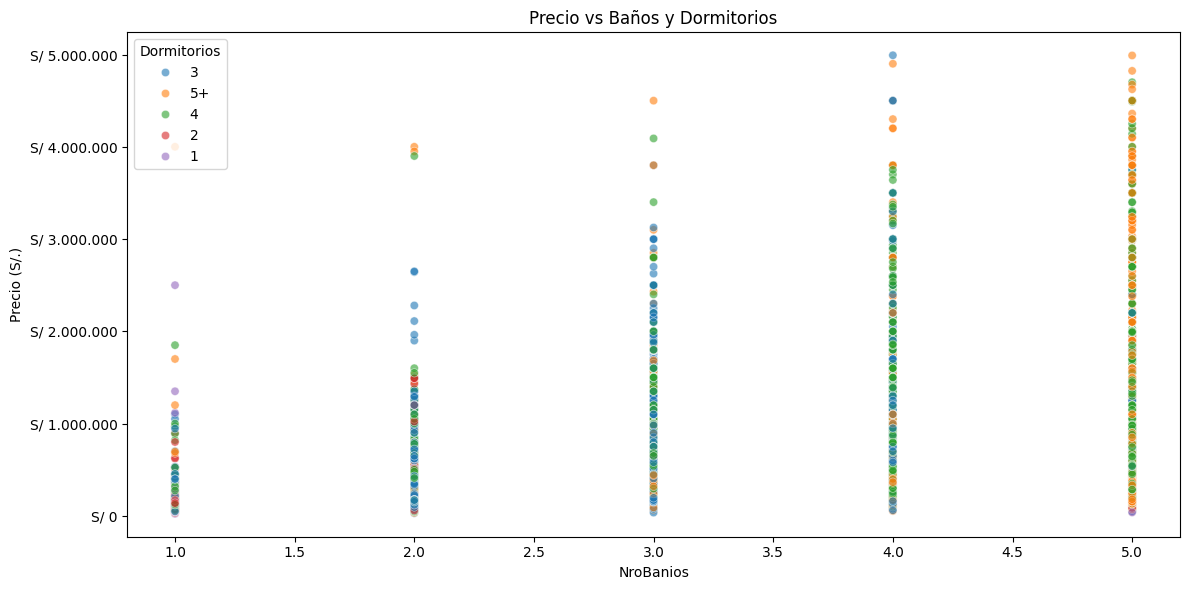

In [ ]:
# Información general
print("\n--- Información del dataset ---")
print(df.info())

# Valores nulos
print("\n--- Valores nulos por columna ---")
valores_nulos = df.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)
print(valores_nulos)

# Visualización de valores nulos
plt.figure(figsize=(10, 6))
sns.barplot(x=valores_nulos.values, y=valores_nulos.index, palette="viridis")
plt.title('Cantidad de Valores Nulos por Columna')
plt.xlabel('Número de Valores Nulos')
plt.ylabel('Columnas')
plt.tight_layout()
plt.show()

# Boxplot para visualizar los outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Precio'])
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('Boxplot de Precio')
plt.xlabel('Precio (S/.)')
plt.tight_layout()
plt.show()


# Distribución original del Precio
plt.figure(figsize=(10, 5))
sns.histplot(df['Precio'], bins=50, kde=True)
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('Distribución del Precio')
plt.xlabel('Precio (S/.)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución logarítmica del Precio
df['Precio_Log'] = np.log1p(df['Precio'])
plt.figure(figsize=(10, 4))
sns.histplot(df['Precio_Log'], bins=50, kde=True, color='orange')
plt.title('Distribución del Precio (Log Transformado)')
plt.xlabel('Log(Precio + 1)')
plt.show()


# Filtrar precios < 5 millones para visualización
df_viz = df[df['Precio'] < 5_000_000]


# Correlaciones con el precio
numericas = df.select_dtypes(include=['float64', 'int64'])
correlaciones = numericas.corr()['Precio'].sort_values(ascending=False)

# Visualización: Top 15 correlaciones
plt.figure(figsize=(12, 6))
sns.barplot(x=correlaciones.head(15).values, y=correlaciones.head(15).index)
plt.title('Top 15 Variables con Mayor Correlación con el Precio')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()


# Mapa de calor de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(numericas.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')
plt.tight_layout()
plt.show()

# Distribución de precios por tipo de propiedad
plt.figure(figsize=(12, 6))
sns.boxplot(x='Tipo', y='Precio', data=df_viz)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=90)
plt.title('Distribución de Precios por Tipo de Propiedad')
plt.ylabel('Precio (S/.)')
plt.tight_layout()
plt.show()

# Relación entre Área Construida y Precio
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='Area_constr_m2', y='Precio')
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Área Construida vs Precio')
plt.xlabel('Área Construida (m²)')
plt.ylabel('Precio (S/.)')
plt.tight_layout()
plt.show()


# Precio promedio por distrito (Top 15)
plt.figure(figsize=(14, 6))
precio_distrito = df_viz.groupby('Distrito')['Precio'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=precio_distrito.index, y=precio_distrito.values)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Precio Promedio por Distrito (Top 15)')
plt.xticks(rotation=90)
plt.ylabel('Precio Promedio (S/.)')
plt.tight_layout()
plt.show()


# Relación entre número de baños, dormitorios y precio
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_viz, x='NroBanios', y='Precio', hue='Dormitorios',
                sizes=(20, 200), alpha=0.6)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Precio vs Baños y Dormitorios')
plt.ylabel('Precio (S/.)')
plt.tight_layout()
plt.show()

# 2. Preparacion de datos ✅

Se realizo lo siguiente:


*   Seleccion de columnas a entrenar
*   Valores categoricos a numericos
*   Se elimino outliers
*   Se creo la variable "Precio_Log"





In [ ]:
# === 2.1 Limpiar nombres de columnas (quitar comillas simples) ANTES de seleccionar
df.columns = df.columns.str.replace("'", "").str.strip()

# === 3. Seleccionar columnas relevantes con nombres limpios
columnas_deseadas = [
    'Precio',  # Variable objetivo
    'Area_constr_m2', 'Area_total_m2', 'Dormitorios', 'NroBanios',
    'Cocheras', 'Antiguedad', 'Estado de Inmueble', 'Tipo',
    'Provincia', 'Distrito',
    'Piscina', 'Gimnasio', 'Sauna', 'Jacuzzi', 'Sotano', 'Walking Closet'
]
df = df[columnas_deseadas].copy()

# === 4. Reemplazar nulos comunes como texto ===
df.replace(to_replace=['Nulo', 'null', 'Null', 'NA', 'N/A', '', 'No disponible'], value=np.nan, inplace=True)

# === 5. Convertir valores problemáticos a numéricos ===
df['Area_total_m2'] = pd.to_numeric(df['Area_total_m2'], errors='coerce')
df['Dormitorios'] = df['Dormitorios'].replace('5+', 5)
df['Dormitorios'] = pd.to_numeric(df['Dormitorios'], errors='coerce')

# === 6. Imputar con mediana ===
for col in ['Area_total_m2', 'Dormitorios']:
    df[col].fillna(df[col].median(), inplace=True)

# === 7. Amenidades: convertir a binario 0/1 ===
amenidades = ['Piscina', 'Gimnasio', 'Sauna', 'Jacuzzi', 'Sotano', 'Walking Closet']
for col in amenidades:
    df[col] = df[col].apply(lambda x: 1 if str(x).strip().lower() == 'presente' else 0)

# === 8. Controlar outliers en Precio (winsorization al percentil 99) ===
p99 = df['Precio'].quantile(0.99)
df['Precio'] = np.minimum(df['Precio'], p99)

# === 9. Crear variable Precio_Log ===
df['Precio_Log'] = np.log1p(df['Precio'])

# === 10. Separar variables para el modelo ===
num_cols = ['Area_constr_m2', 'Area_total_m2', 'Dormitorios', 'NroBanios', 'Cocheras', 'Antiguedad']
cat_cols = ['Estado de Inmueble', 'Tipo', 'Provincia', 'Distrito']
bin_cols = amenidades

Se reune toda la categorizacion y el escalado en un pipeline para el entrenamiento


In [ ]:
X = df[num_cols + cat_cols + bin_cols]
y = df['Precio_Log']

# Pipelines por tipo de columna
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
], remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 🤖 Entrenamiento de Modelos

Se entreno los siguientes modelos:


*   Regresión Lineal
*   Ridge Regression
*   Lasso Regression
*   Random Forest Regressor
*   XGBoost Regressor






In [ ]:
X_train_proc= preprocessor.fit_transform(X_train)
X_test_proc= preprocessor.transform(X_test)

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

resultados_modelos = {}
predicciones_modelos = {}

# Función auxiliar para evaluar
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n{nombre}")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R²:", r2)

    resultados_modelos[nombre] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

    predicciones_modelos[nombre] = (y_test, y_pred)

# --- Regresión Lineal ---
modelo_lr = LinearRegression()
modelo_lr.fit(X_train_proc, y_train)
evaluar_modelo("Regresión Lineal", modelo_lr, X_test_proc, y_test)

# --- Ridge Regression ---
param_grid_ridge = {'alpha': [0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=kf, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train_proc, y_train)
modelo_ridge = grid_ridge.best_estimator_
evaluar_modelo(f"Ridge Regression (alpha={grid_ridge.best_params_['alpha']})", modelo_ridge, X_test_proc, y_test)

# --- Lasso Regression ---
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1]}
grid_lasso = GridSearchCV(Lasso(max_iter=5000), param_grid_lasso, cv=kf, scoring='neg_mean_squared_error')
grid_lasso.fit(X_train_proc, y_train)
modelo_lasso = grid_lasso.best_estimator_
evaluar_modelo(f"Lasso Regression (alpha={grid_lasso.best_params_['alpha']})", modelo_lasso, X_test_proc, y_test)

# --- Random Forest Regressor ---
modelo_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
modelo_rf.fit(X_train_proc, y_train)
evaluar_modelo("Random Forest", modelo_rf, X_test_proc, y_test)

# --- XGBoost Regressor ---
modelo_xgb = XGBRegressor(n_estimators=300, max_depth=6, subsample=0.8, colsample_bytree=0.8, learning_rate=0.1, random_state=42)
modelo_xgb.fit(X_train_proc, y_train)
evaluar_modelo("XGBoost", modelo_xgb, X_test_proc, y_test)


Regresión Lineal
MAE: 0.3207661657347386
RMSE: 0.42048876723689926
R²: 0.754022536294576

Ridge Regression (alpha=1)
MAE: 0.32008634485938314
RMSE: 0.4183178631364863
R²: 0.7565558502487455

Lasso Regression (alpha=0.001)
MAE: 0.3292452896882741
RMSE: 0.4263904364223662
R²: 0.7470693662306293

Random Forest
MAE: 0.26319656429651833
RMSE: 0.3590222547757452
R²: 0.8206797804583832

XGBoost
MAE: 0.22945273959807147
RMSE: 0.31196291505690205
R²: 0.8646081690539115


Se concluyo que XGBoost es el que tiene mejores metricas y se exporto

In [ ]:
# Pipeline completo con XGBoost
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, "pipeline_xgb_modelo_completo.pkl")

['pipeline_xgb_modelo_completo.pkl']

# 3. 👀 Visualización de resultados

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_metricas(resultados_modelos):
    modelos = list(resultados_modelos.keys())
    mae = [resultados_modelos[m]["MAE"] for m in modelos]
    rmse = [resultados_modelos[m]["RMSE"] for m in modelos]
    r2 = [resultados_modelos[m]["R2"] for m in modelos]

    x = np.arange(len(modelos))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, mae, width, label='MAE')
    plt.bar(x, rmse, width, label='RMSE')
    plt.bar(x + width, r2, width, label='R²')
    plt.xticks(x, modelos, rotation=45)
    plt.ylabel("Valor de la métrica")
    plt.title("Comparación de métricas entre modelos")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def graficar_dispersión(predicciones_modelos):
    for nombre, (y_real, y_pred) in predicciones_modelos.items():
        plt.figure(figsize=(6, 6))
        plt.scatter(y_real, y_pred, alpha=0.5)
        plt.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], 'r--')  # Línea ideal
        plt.xlabel("Valor real")
        plt.ylabel("Valor predicho")
        plt.title(f"Dispersión: {nombre}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

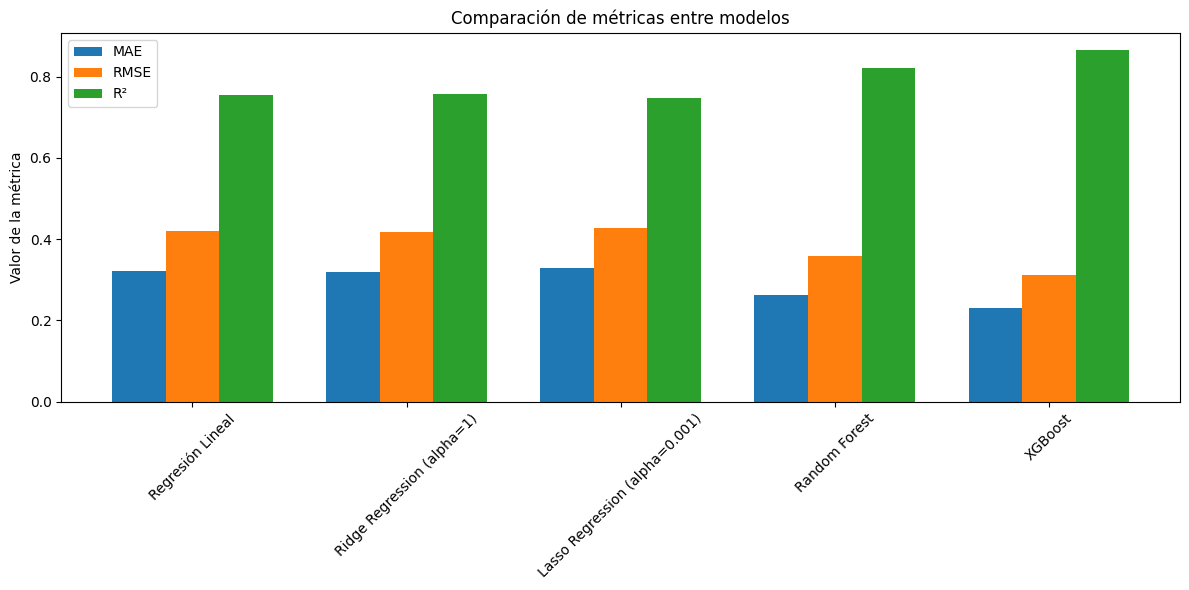

In [ ]:
graficar_metricas(resultados_modelos)

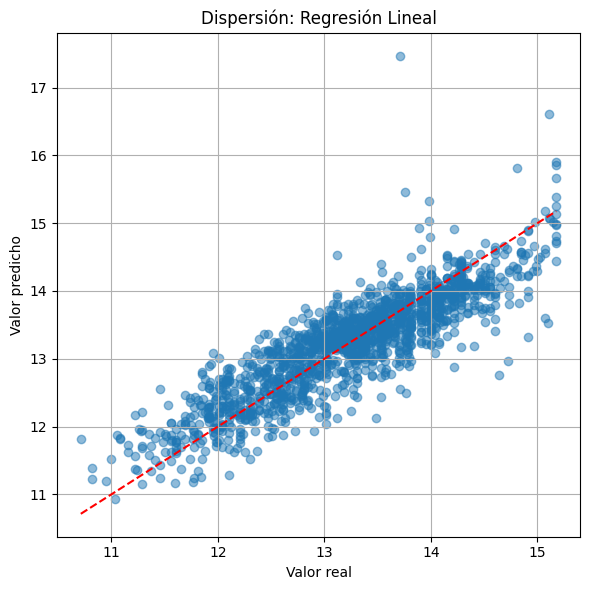

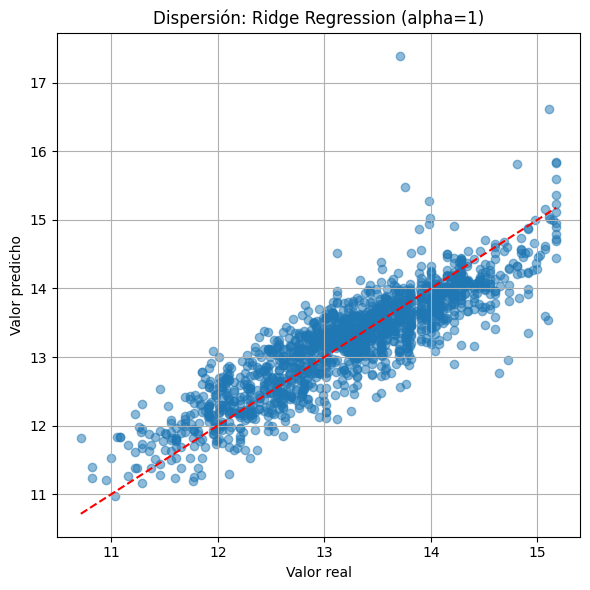

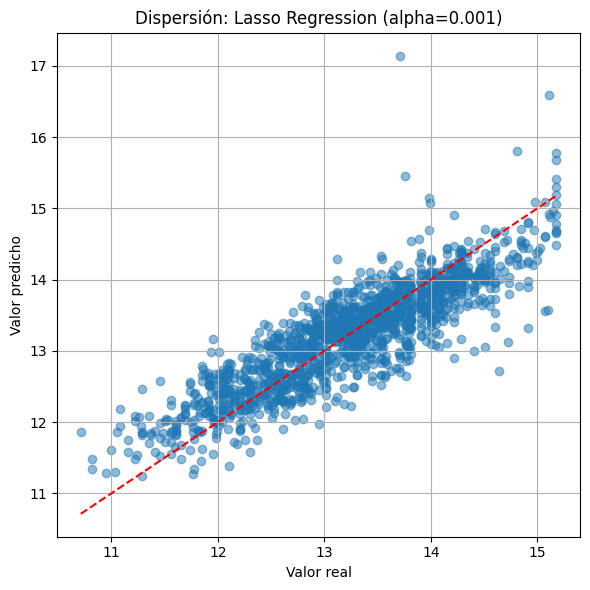

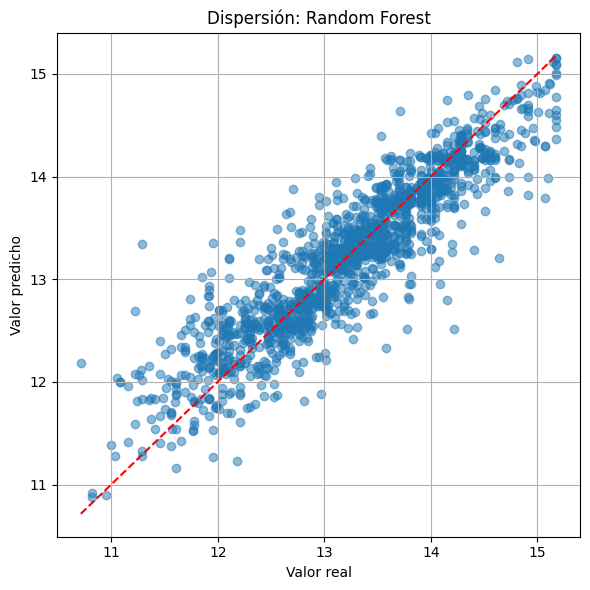

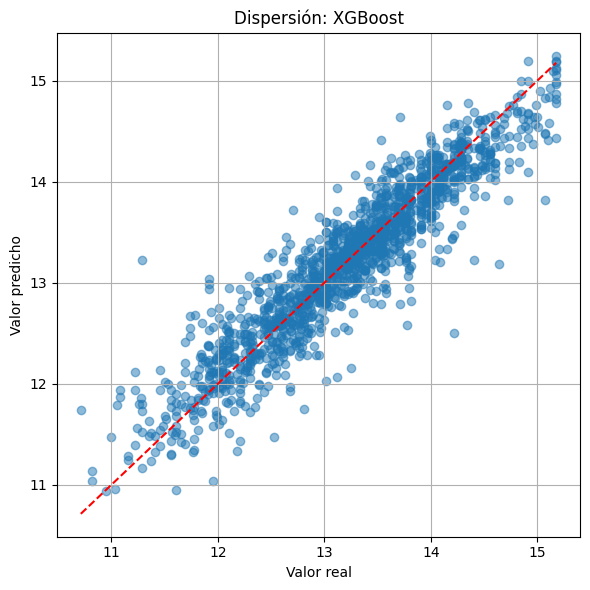

In [ ]:
graficar_dispersión(predicciones_modelos)

In [ ]:
X_test_proc = X_test_proc.astype(np.float64)

# 5. 🎯 Interpretabilidad del Modelo

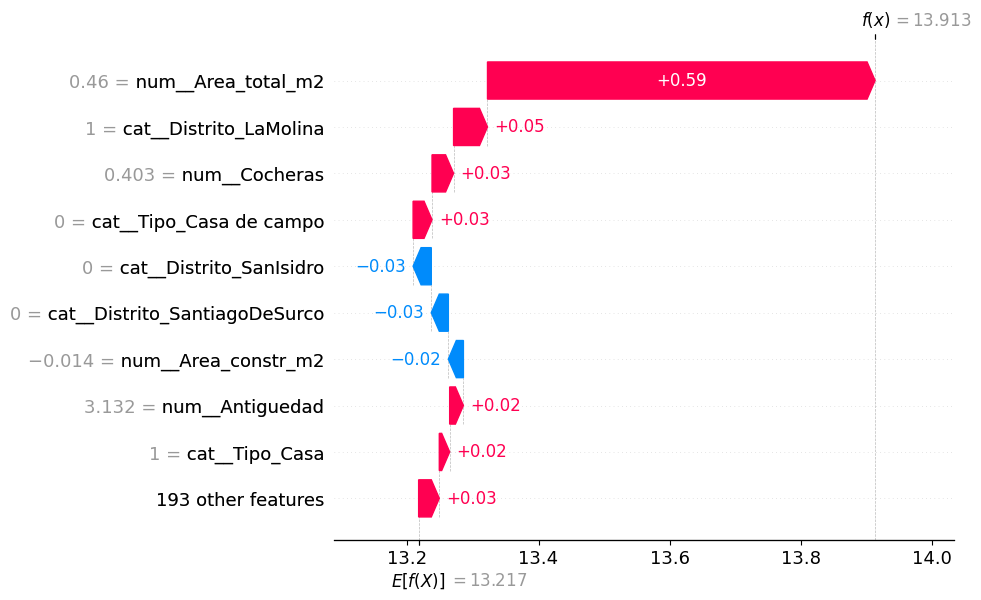

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Asegurarse de que X_test_proc es float and convert sparse matrix to dense array
X_test_proc = X_test_proc.astype(np.float64).toarray()

# Crear el TreeExplainer con el modelo ya entrenado
explainer = shap.TreeExplainer(modelo_rf)

# Calcular los valores SHAP sobre los datos preprocesados
shap_values = explainer.shap_values(X_test_proc)

# Obtener los nombres de las columnas transformadas
feature_names = preprocessor.get_feature_names_out()

# Seleccionar la observación a explicar (por índice)
index = 10

# Crear la explicación con SHAP
exp = shap.Explanation(
    values=shap_values[index],
    base_values=explainer.expected_value,
    data=X_test_proc[index],
    feature_names=feature_names
)

# Graficar la explicación tipo waterfall
shap.plots.waterfall(exp)

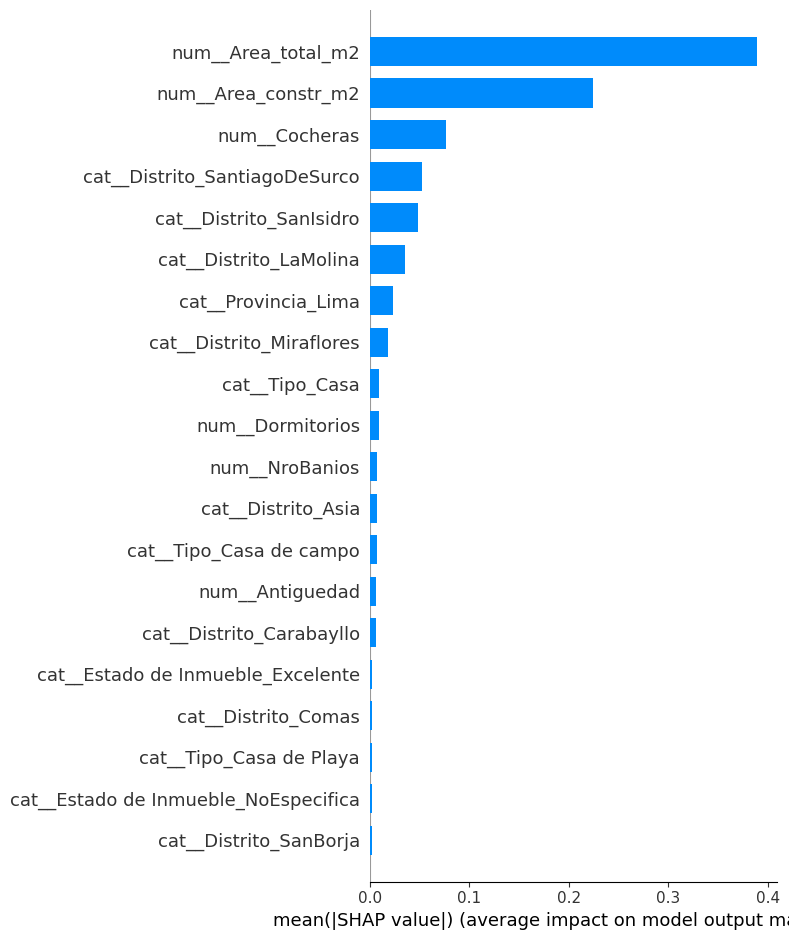

In [ ]:
# Summary plot clásico
shap.summary_plot(shap_values, X_test_proc, feature_names=feature_names, plot_type="bar")  # Importancia global

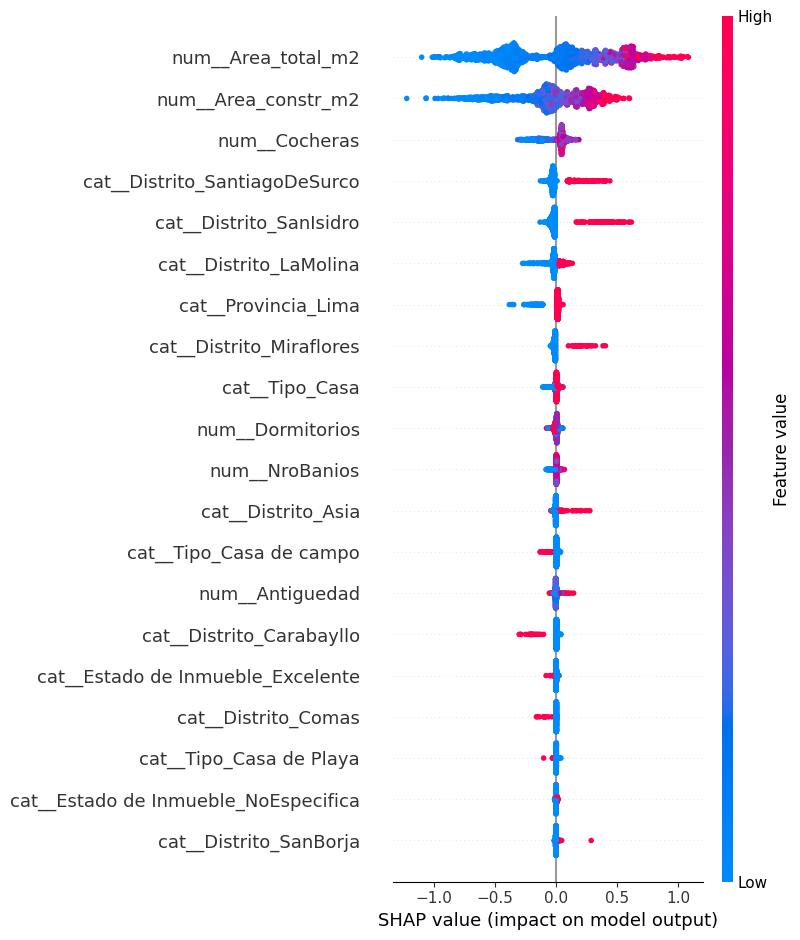

In [ ]:
shap.summary_plot(shap_values, X_test_proc, feature_names=feature_names)  # Dispersión SHAP vs feature value

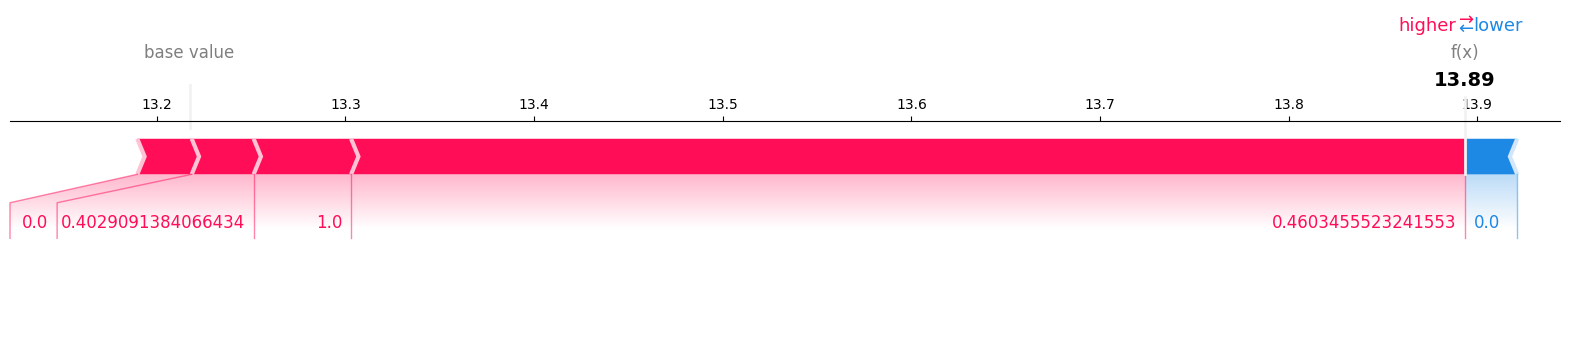

In [ ]:
# Filtrar las 5 variables más relevantes (en valor absoluto)
import numpy as np
top_features = np.argsort(np.abs(shap_values[index]))[::-1][:5]

# Generar nuevo force_plot con solo esas variables
shap.force_plot(
    explainer.expected_value,
    shap_values[index][top_features],
    X_test_proc[index, top_features],
    matplotlib=True
)